In [1]:
%run ../../../__init__.py
%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Training loss

In [2]:
from omegaconf import OmegaConf
from hydra import compose, initialize

model = 'shiners_disk/default'

train_overrides = [f"+models/{model}=custom",
                   "+datasets/megadepth/setup/CUSTOM=train",
                   "+experiment=custom"]

with initialize(config_path="../../../../config"):
    config = compose(overrides=train_overrides)
    
    print(OmegaConf.to_yaml(config))
    
    OmegaConf.set_struct(config, False)
    
    experiment = SummertimeExperiment(config)
    batch, endpoint, metrics = experiment.run()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  # Remove the CWD from sys.path while we load stuff.


models:
  shiners:
    input_size_divisor: 16
    modules:
      detector:
        idx: 0
        default_idx: 0
        process_idx: 0
        ners:
          feature_channels: 3
          down:
          - 16
          - 32
          - 64
          - 64
          - 64
          up:
          - 64
          - 64
          - 64
          - 1
        shi:
          sobel_size: 3
          window_size: 3
          window_cov: 2
          loc: true
    eval_params:
      nms_size: 5
      score_thresh: 0.0
    checkpoint:
      rel_path: models/shiners
      name: r_mAA-t_mAA=0.6579
  disk:
    input_channels: 3
    input_size_divisor: 16
    modules:
      descriptor:
        idx: 1
        default_idx: 1
        process_idx: 1
    checkpoint:
      name: depth-save
      rel_path: models/disk
      remap: true
    eval_params:
      matcher:
        name: l2
  model_name: shiners_disk
datasets:
  megadepth:
    custom:
      csv_path: /mnt/sda/datasets/MegaDepth/SceneInfo/train_disk.csv

/opt/conda/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/konstantin/personal/Summertime/source/utils/endpoint_utils.py:375: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y = flat_ids // w
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. 

In [3]:
from copy import deepcopy

ners_detector = deepcopy(experiment.model_wrapper.modules_wrappers[0].detector)

scale_factor = 2.0
num_samples = 100

config = OmegaConf.create({'topk': 1024,
                           'nms_size': 5,
                           'score_thresh': 0.005})

patch_size = config.nms_size + ners_detector.base_detector.get_border_size() * 2
scaled_patch_size = int(patch_size * scale_factor) // 2 * 2 + 1

ners_detector.base_detector.set_border_size(scaled_patch_size + int(4 * scale_factor))
ners_detector.base_detector.set_loc(False)

In [4]:
import source.models.ness.modules_wrappers.namespace as n_ns

image = batch[du.IMAGE1]
image_gray = batch[du.IMAGE_GRAY1]
ners = endpoint[n_ns.NERS1]

In [5]:
kp, kp_score, kp_base_score = ners_detector(image_gray, ners.detach(), config)

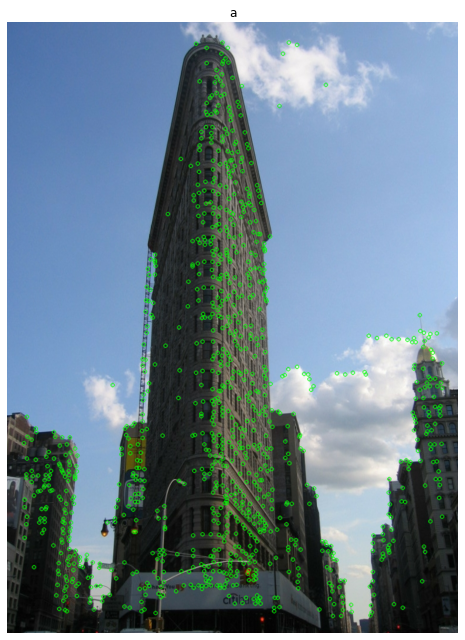

In [6]:
plot_figures({'a': draw_cv_keypoints(image, kp, draw_mask=kp_score > config.score_thresh)}, 1, 1, (16, 9))

In [7]:
from source.models.ness.criteria.homography import generate_homographies

kp_mask = kp_base_score > config.score_thresh

h_data = generate_homographies(scaled_patch_size,
                               scale_factor, num_samples,
                               experiment.device)

In [8]:
from source.models.ness.criteria.keypoint_scores import get_repeatability_score

kp_rs = get_repeatability_score(image_gray, kp, h_data,
                                scaled_patch_size, patch_size,
                                num_samples,
                                config.topk, config.nms_size, 
                                ners_detector.base_detector)

In [9]:
from source.utils.endpoint_utils import sample_tensor

kp_ners = sample_tensor(ners, kp, ners.shape).squeeze(-1)

In [10]:
from source.models.ness.criteria.mse_loss import mse_loss

mse_loss(kp_ners, kp_rs, kp_mask)

tensor(0.0295)

(array([314., 100.,  76.,  81.,  57.,  53.,  42.,  56.,  59., 186.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

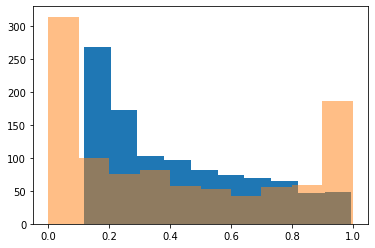

In [11]:
plt.hist(kp_ners[0, kp_mask[0]].numpy())
plt.hist(kp_rs[0, kp_mask[0]].numpy(), alpha=0.5)